In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from systole import import_ppg
from systole.detection import oxi_peaks, missed_beat, artifact_removal
from systole.hrv import time_domain
from adtk.detector import QuantileAD, GeneralizedESDTestAD
from adtk.visualization import plot
from adtk.data import validate_series

Here, we describe the default method used to detect and remove artifacts and outliers in PPG recording. We use the [Anomaly Detection Toolkit](https://arundo-adtk.readthedocs-hosted.com/en/latest/index.html) to detect volatility changes in PPG recording and spikes in R-R time series.

In [2]:
oxi = import_ppg('1')[0, :]

# Artefact detection and correction

In [24]:
# Extract peak vectors
signal, peaks = oxi_peaks(oxi)

# Remove 3 consecutive beats
peaks[np.where(peaks)[0][50:53]] = 0

# Remove 2 consecutive beats
peaks[np.where(peaks)[0][100:101]] = 0

# Store into a Panda DataFrame
rr = np.diff(np.where(peaks))[0]
time = pd.to_datetime(np.cumsum(rr), unit='ms')
df = pd.DataFrame({'rr': rr}, index=time)
df = validate_series(df.rr)

In [25]:
# Artefact correction
clean_peaks, per = artifact_removal(peaks)

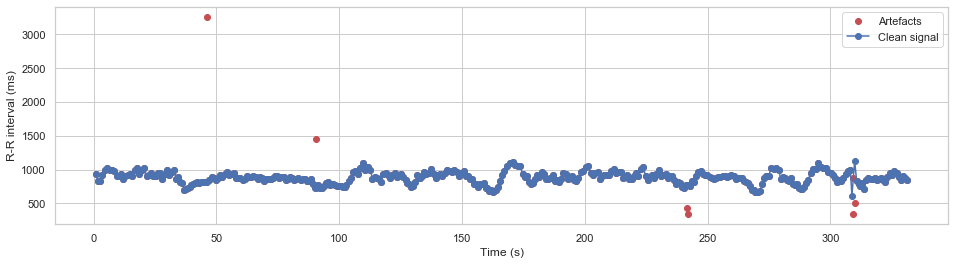

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(np.cumsum(np.diff(np.where(peaks)[0]))/1000,
         np.diff(np.where(peaks)[0]), 'ro', label='Artefacts')  # Artefacts
plt.plot(np.cumsum(np.diff(np.where(clean_peaks)[0]))/1000,
         np.diff(np.where(clean_peaks)[0]), 'bo-', label='Clean signal')  # Cleaned peaks
plt.ylabel('R-R interval (ms)')
plt.xlabel('Time (s)')
plt.legend()

# Test functions

The procedure prviously describe is implemented in the artifact_removal() function.

## Test with extrabeats

In [37]:
#signal, peaks = oxi_peaks(oxi)
time_domain(np.diff(np.where(peaks)[0]))

,Values,Metric
0,879.00,MeanRR
1,68.94,MeanBPM
2,882.00,MedianRR
3,68.03,MedianBPM
4,664.00,MinRR
5,53.67,MinBPM
6,1118.00,MaxRR
7,90.36,MaxBPM
8,85.67,SDNN
9,46.81,RMSSD


In [47]:
rms = []
for i in range(100):
    noisy_peaks = peaks.copy()
    
    # Add extra beats (n=5)
    idx = np.random.choice(np.where(noisy_peaks==0)[0], size=5)
    noisy_peaks[idx] = 1
    
    # Apply artifact correction
    clean_peaks, per = artifact_removal(noisy_peaks)
    stats = time_domain(np.diff(np.where(clean_peaks)[0]))
    rms.append(stats.Values[stats.Metric=='RMSSD'].iloc[0])

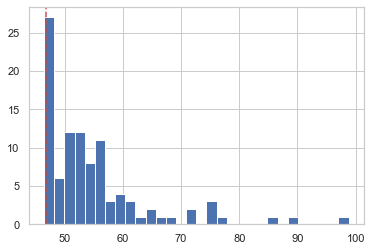

In [48]:
plt.hist(rms, bins=30)
plt.axvline(x=46.81, color='r', linestyle='--')

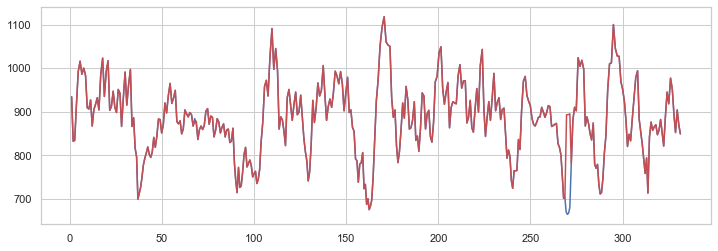

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(np.diff(np.where(peaks)[0]))/1000,
         np.diff(np.where(peaks)[0]))
plt.plot(np.cumsum(np.diff(np.where(clean_peaks)[0]))/1000,
         np.diff(np.where(clean_peaks)[0]), 'r')

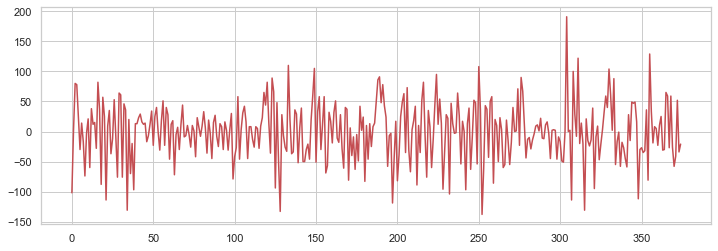

In [53]:
plt.figure(figsize=(12, 4))
plt.plot(np.diff(np.diff(np.where(clean_peaks)[0])), 'r')

In [76]:
from scipy import interpolate
rr = np.diff(np.where(clean_peaks)[0])
time = np.arange(0, len(rr))

# Remove value
rr_mising = np.delete(rr, 50)
time_missing = np.delete(time, 50)

f = interpolate.interp1d(time_missing, rr_mising, kind='cubic')
new_rr = f(time)

(25, 75)

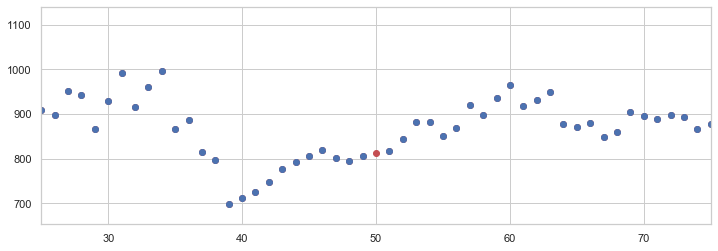

In [77]:
plt.figure(figsize=(12, 4))
plt.plot(time, new_rr, 'ro')
plt.plot(time_missing, rr_mising, 'bo')
plt.xlim(25, 75)

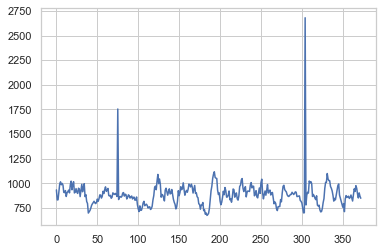

In [82]:
plt.plot(np.diff(np.where(noisy_peaks)[0]))

In [83]:
np.where(np.diff(np.where(noisy_peaks)[0]) > 1250)

(array([ 75, 304], dtype=int64),)

(50, 100)

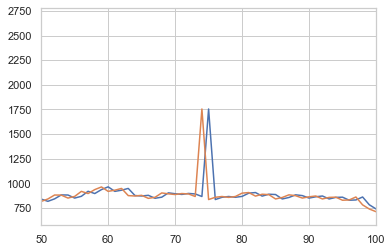

In [153]:
plt.plot(np.diff(np.where(noisy_peaks)[0]))

plt.plot(np.diff(np.where(final_peaks)[0]))
plt.xlim(50, 100)

# The 3 most common artefacts types

Three most common artefact types in HRV time series are extra, missed and ectopic beats (see Lipponen & Tarvainen, 2019).

## Missed beats

Missed beats are corrected by adding new R-wave occurrence time so that it divides the detected long RR interval into two equal halves and RR interval series is then recalculated (see Lipponen & Tarvainen, 2019).

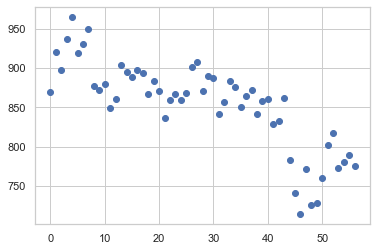

In [222]:
signal, peaks = oxi_peaks(oxi)
peaks = peaks[50000:100000]
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

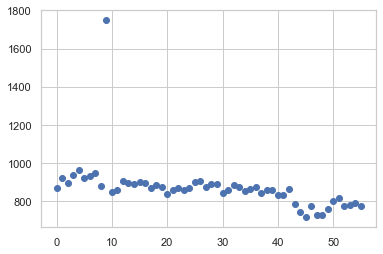

In [223]:
# Add peak
idx = np.where(peaks)[0][10]
peaks[idx] = 0
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

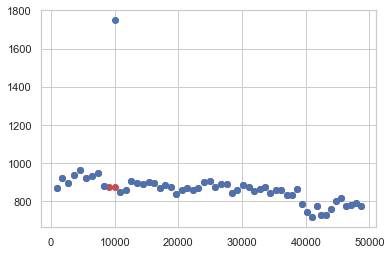

In [224]:
idx = np.argmax(np.diff(np.where(peaks)[0]) > 1200)
new_peaks, per = missed_beat(peaks, idx)

plt.plot(np.cumsum(np.diff(np.where(new_peaks)[0])),
         np.diff(np.where(new_peaks)[0]), 'ro')

plt.plot(np.cumsum(np.diff(np.where(peaks)[0])),
         np.diff(np.where(peaks)[0]), 'bo')

Here, we will assuma that one peaks is missing, and will thus remove the outlier R-R interval and interpolate 2 new values.

## Test

In [244]:
signal, peaks = oxi_peaks(oxi)

In [246]:
stats = time_domain(np.diff(np.where(peaks)[0]))

In [256]:
rms = []
for i in range(100):
    noisy_peaks = peaks.copy()
    
    # Add extra beats (n=1)
    idx = np.random.choice(np.where(noisy_peaks==1)[0][2:-2], size=1)
    noisy_peaks[idx] = 0
    
    # Apply artifact correction
    clean_peaks, per = artifact_removal(noisy_peaks)
    stats = time_domain(np.diff(np.where(clean_peaks)[0]))
    rms.append(stats.Values[stats.Metric=='RMSSD'].iloc[0])

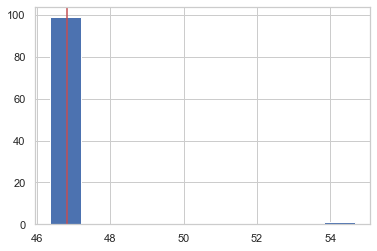

In [257]:
plt.hist(rms)
plt.axvline(stats.Values[stats.Metric=='RMSSD'].iloc[0], color='r')

## Extra beats

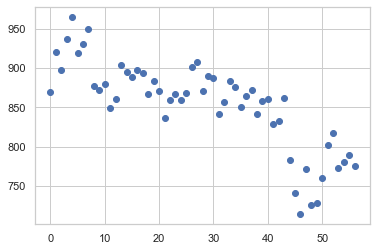

In [298]:
signal, peaks = oxi_peaks(oxi)
peaks = peaks[50000:100000]
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

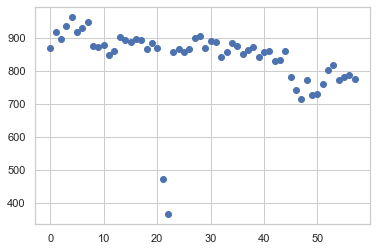

In [299]:
# Add beat
idx = np.where(peaks == 0)[0][20000]
peaks[idx] = 1
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

Ths can easily be corrected by removing the first outlier and recomputing the RR time series. This procedure can be repeated until no outlier is found.

In [300]:
while np.any(np.diff(np.where(peaks)[0]) < 600):
    # Find outliers using threshold
    idx = np.where(np.diff(np.where(peaks)[0]) < 600)[0]
    peaks[np.where(peaks)[0][idx[0]+1]] = 0

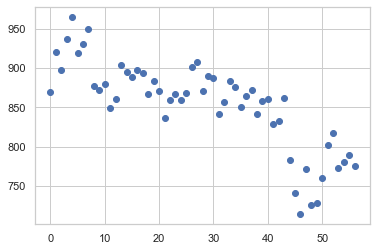

In [301]:
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

# References

Rincon Soler, A. I., Silva, L. E. V., Fazan, R., Jr., & Murta, L. O., Jr. (2018). The impact of artifact correction methods of RR series on heart rate variability parameters. Journal of Applied Physiology, 124(3), 646–652. https://doi.org/10.1152/japplphysiol.00927.2016

Al Osman, H., Eid, M., & El Saddik, A. (2015). A Pattern-Based Windowed Impulse Rejection Filter for Nonpathological HRV Artifacts Correction. IEEE Transactions on Instrumentation and Measurement, 64(7), 1944–1957. https://doi.org/10.1109/tim.2014.2370496

Lippman, N., Stein, K. M., & Lerman, B. B. (1994). Comparison of methods for removal of ectopy in measurement of heart rate variability. The American Journal of Physiology, 267, H411–H418.

Morelli, D., Rossi, A., Cairo, M., & Clifton, D. A. (2019). Analysis of the Impact of Interpolation Methods of Missing RR-intervals Caused by Motion Artifacts on HRV Features Estimations. Sensors, 19(14), 3163. https://doi.org/10.3390/s19143163

Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time series artefact correction using novel beat classification. Journal of Medical Engineering & Technology, 43(3), 173–181. https://doi.org/10.1080/03091902.2019.1640306
